## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 7 slices in the middle
* slide inference

In [1]:
# !pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
# !pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
# !pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
# !pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [2]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [3]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [4]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

In [5]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [6]:
import segmentation_models_pytorch as smp

In [7]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [8]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '../input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'resnet-exp017'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    # backbone = 'se_resnext50_32x4d'
    backbone = 'se_resnext101_32x4d'

    in_chans = 8 # 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 30 # 15

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 3 #1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'../output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(p=0.75),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3), 
                        mask_fill_value=0, p=0.5),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


## helper

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [11]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [12]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [13]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [14]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [15]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [16]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [17]:
# valid_xyxys = np.stack(valid_xyxys)

## dataset

In [18]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [19]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [20]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [21]:
train_dataset[0][0].shape

torch.Size([8, 224, 224])

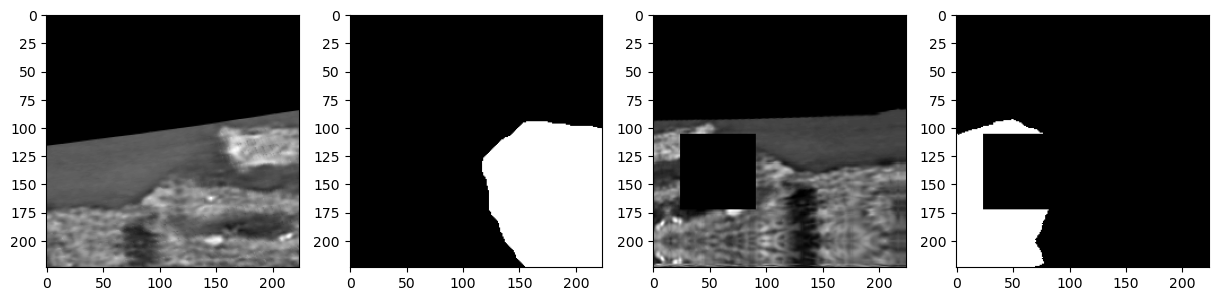

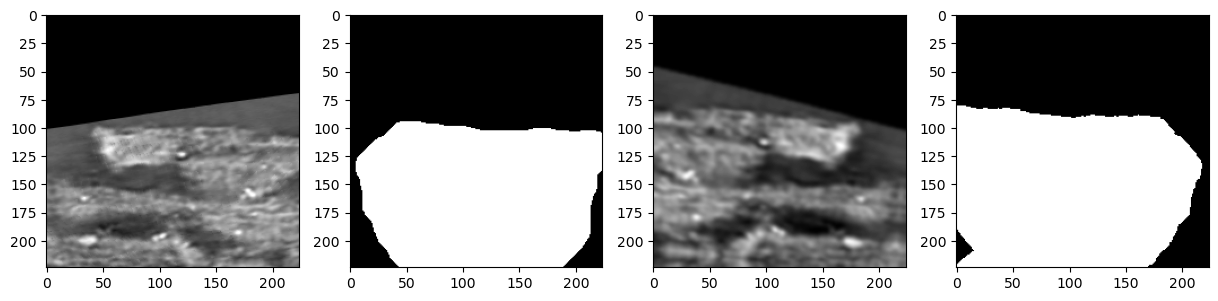

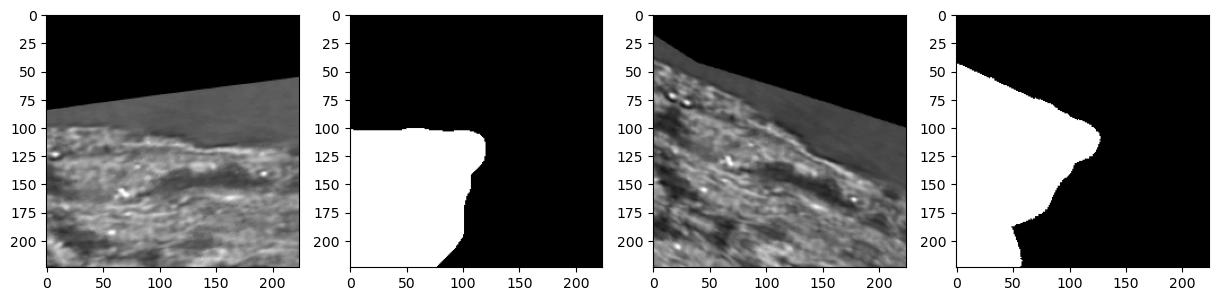

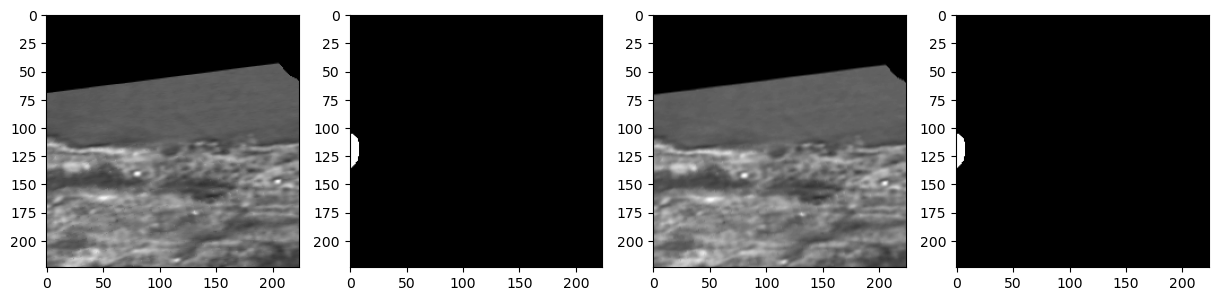

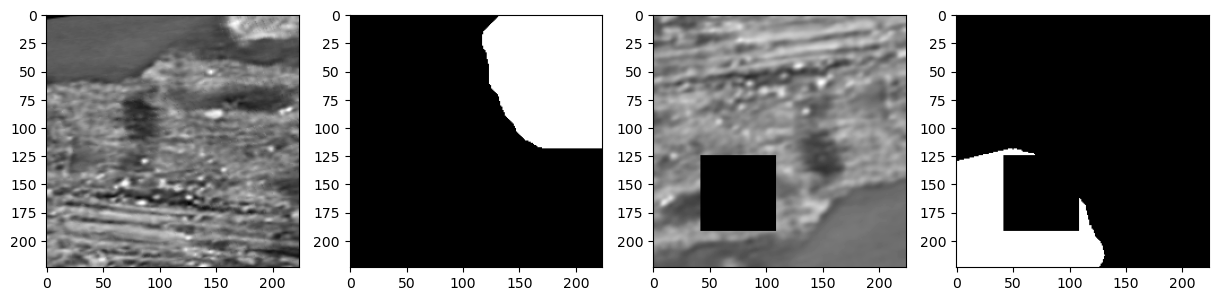

In [22]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [23]:
del plot_dataset
gc.collect()

48115

## model

In [24]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [25]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [26]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [27]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [28]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone se_resnext101_32x4d


## loss

In [29]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [30]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [31]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [32]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [33]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.14393422738878245
th: 0.15, fbeta: 0.18144646047408494
th: 0.2, fbeta: 0.22898845313562338
th: 0.25, fbeta: 0.2797141097483064
th: 0.3, fbeta: 0.32376252441822373
th: 0.35, fbeta: 0.3571562500243786
th: 0.4, fbeta: 0.37449160542412574
th: 0.45, fbeta: 0.3177724854314106


best_th: 0.4, fbeta: 0.37449160542412574
Epoch 1 - avg_train_loss: 0.3938  avg_val_loss: 0.2782  time: 240s
Epoch 1 - avgScore: 0.3745
Epoch 1 - Save Best Score: 0.3745 Model
Epoch 1 - Save Best Loss: 0.2782 Model


th: 0.5, fbeta: 0.09247990652174319


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.18698465393864938
th: 0.15, fbeta: 0.28130256360337624
th: 0.2, fbeta: 0.34995390998533243
th: 0.25, fbeta: 0.3929205704197871
th: 0.3, fbeta: 0.4218696263603623
th: 0.35, fbeta: 0.4392226941924378
th: 0.4, fbeta: 0.4482661734642172
th: 0.45, fbeta: 0.4141975741105859


best_th: 0.4, fbeta: 0.4482661734642172
Epoch 2 - avg_train_loss: 0.3002  avg_val_loss: 0.2372  time: 242s
Epoch 2 - avgScore: 0.4483
Epoch 2 - Save Best Score: 0.4483 Model
Epoch 2 - Save Best Loss: 0.2372 Model


th: 0.5, fbeta: 0.13547875034255208


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


th: 0.1, fbeta: 0.22912284611088615
th: 0.15, fbeta: 0.2702675342788517
th: 0.2, fbeta: 0.30040004006181054
th: 0.25, fbeta: 0.32802205685003033
th: 0.3, fbeta: 0.35428016463398243
th: 0.35, fbeta: 0.37696199259882196
th: 0.4, fbeta: 0.3981160608657284
th: 0.45, fbeta: 0.41876572200015444


best_th: 0.5, fbeta: 0.4384840350771413
Epoch 3 - avg_train_loss: 0.2625  avg_val_loss: 0.2262  time: 238s
Epoch 3 - avgScore: 0.4385


th: 0.5, fbeta: 0.4384840350771413


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2760057696914713
th: 0.15, fbeta: 0.322107223152516
th: 0.2, fbeta: 0.3595199340057886
th: 0.25, fbeta: 0.39092819467766105
th: 0.3, fbeta: 0.42250193864859487
th: 0.35, fbeta: 0.452838986289529
th: 0.4, fbeta: 0.47748612417145936
th: 0.45, fbeta: 0.4946567501942599


best_th: 0.5, fbeta: 0.506795445385124
Epoch 4 - avg_train_loss: 0.2368  avg_val_loss: 0.2052  time: 240s
Epoch 4 - avgScore: 0.5068
Epoch 4 - Save Best Score: 0.5068 Model
Epoch 4 - Save Best Loss: 0.2052 Model


th: 0.5, fbeta: 0.506795445385124


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2810917516101808
th: 0.15, fbeta: 0.3396998202979824
th: 0.2, fbeta: 0.3880958912331559
th: 0.25, fbeta: 0.42344921628346277
th: 0.3, fbeta: 0.4514192874672683
th: 0.35, fbeta: 0.4777336985427175
th: 0.4, fbeta: 0.49835652144376624
th: 0.45, fbeta: 0.514620126003705


best_th: 0.5, fbeta: 0.5265721689689208
Epoch 5 - avg_train_loss: 0.2232  avg_val_loss: 0.1968  time: 242s
Epoch 5 - avgScore: 0.5266
Epoch 5 - Save Best Score: 0.5266 Model
Epoch 5 - Save Best Loss: 0.1968 Model


th: 0.5, fbeta: 0.5265721689689208


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.23186431734466556
th: 0.15, fbeta: 0.2594194728952551
th: 0.2, fbeta: 0.2852254928006072
th: 0.25, fbeta: 0.30927971832929135
th: 0.3, fbeta: 0.3329781853574465
th: 0.35, fbeta: 0.3573321894567934
th: 0.4, fbeta: 0.3824469416830933
th: 0.45, fbeta: 0.409235922976951


best_th: 0.5, fbeta: 0.4352217931175212
Epoch 6 - avg_train_loss: 0.2108  avg_val_loss: 0.2516  time: 239s
Epoch 6 - avgScore: 0.4352


th: 0.5, fbeta: 0.4352217931175212


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.28368904191800765
th: 0.15, fbeta: 0.3329357423540219
th: 0.2, fbeta: 0.377989292185427
th: 0.25, fbeta: 0.4179541950388784
th: 0.3, fbeta: 0.4499033496033549
th: 0.35, fbeta: 0.47310402550715175
th: 0.4, fbeta: 0.496707262031605
th: 0.45, fbeta: 0.517329927663866


best_th: 0.5, fbeta: 0.5357624053946305
Epoch 7 - avg_train_loss: 0.1985  avg_val_loss: 0.2055  time: 240s
Epoch 7 - avgScore: 0.5358
Epoch 7 - Save Best Score: 0.5358 Model
Epoch 7 - Save Best Loss: 0.2055 Model


th: 0.5, fbeta: 0.5357624053946305


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3519954983442022
th: 0.15, fbeta: 0.3944932780482931
th: 0.2, fbeta: 0.4273728176407981
th: 0.25, fbeta: 0.4523648835328106
th: 0.3, fbeta: 0.4742661516856333
th: 0.35, fbeta: 0.4938529311008666
th: 0.4, fbeta: 0.5128341138532757
th: 0.45, fbeta: 0.5301236800970707


best_th: 0.5, fbeta: 0.5440501252231679
Epoch 8 - avg_train_loss: 0.1867  avg_val_loss: 0.2137  time: 240s
Epoch 8 - avgScore: 0.5441
Epoch 8 - Save Best Score: 0.5441 Model
Epoch 8 - Save Best Loss: 0.2137 Model


th: 0.5, fbeta: 0.5440501252231679


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.39658134323848104
th: 0.15, fbeta: 0.44145091417463583
th: 0.2, fbeta: 0.47013195842184735
th: 0.25, fbeta: 0.49305423280154687
th: 0.3, fbeta: 0.5110064155575639
th: 0.35, fbeta: 0.5244857702436239
th: 0.4, fbeta: 0.5367956202208112
th: 0.45, fbeta: 0.5458171400035327


best_th: 0.5, fbeta: 0.5492140061906625
Epoch 9 - avg_train_loss: 0.1745  avg_val_loss: 0.2048  time: 242s
Epoch 9 - avgScore: 0.5492
Epoch 9 - Save Best Score: 0.5492 Model
Epoch 9 - Save Best Loss: 0.2048 Model


th: 0.5, fbeta: 0.5492140061906625


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.29783363800192675
th: 0.15, fbeta: 0.33251017130854693
th: 0.2, fbeta: 0.36236215178421954
th: 0.25, fbeta: 0.38791632124850856
th: 0.3, fbeta: 0.40817660841526204
th: 0.35, fbeta: 0.4276211670633782
th: 0.4, fbeta: 0.4444822438509947
th: 0.45, fbeta: 0.46236572046528807


best_th: 0.5, fbeta: 0.4806170710140876
Epoch 10 - avg_train_loss: 0.1647  avg_val_loss: 0.2287  time: 241s
Epoch 10 - avgScore: 0.4806


th: 0.5, fbeta: 0.4806170710140876


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.34852264727941157
th: 0.15, fbeta: 0.3799050701757744
th: 0.2, fbeta: 0.4078610771364261
th: 0.25, fbeta: 0.43480578338835624
th: 0.3, fbeta: 0.45904160291951046
th: 0.35, fbeta: 0.4797328413208796
th: 0.4, fbeta: 0.49681833967523004
th: 0.45, fbeta: 0.510816269308059


best_th: 0.5, fbeta: 0.5204635255185769
Epoch 11 - avg_train_loss: 0.1543  avg_val_loss: 0.2282  time: 240s
Epoch 11 - avgScore: 0.5205


th: 0.5, fbeta: 0.5204635255185769


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.28903999858360124
th: 0.15, fbeta: 0.3234457131109274
th: 0.2, fbeta: 0.35005763628866493
th: 0.25, fbeta: 0.37317453228849035
th: 0.3, fbeta: 0.3980186558326093
th: 0.35, fbeta: 0.4207607021635763
th: 0.4, fbeta: 0.44175932573944365
th: 0.45, fbeta: 0.46080544321625455


best_th: 0.5, fbeta: 0.4778839699494634
Epoch 12 - avg_train_loss: 0.1435  avg_val_loss: 0.2257  time: 240s
Epoch 12 - avgScore: 0.4779


th: 0.5, fbeta: 0.4778839699494634


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.32076057928725216
th: 0.15, fbeta: 0.35339708106612017
th: 0.2, fbeta: 0.3832517453597741
th: 0.25, fbeta: 0.40873929462496617
th: 0.3, fbeta: 0.42746716564956966
th: 0.35, fbeta: 0.4443068718472085
th: 0.4, fbeta: 0.45837850182175804
th: 0.45, fbeta: 0.46689119027295434


best_th: 0.5, fbeta: 0.47253584594467346
Epoch 13 - avg_train_loss: 0.1353  avg_val_loss: 0.2398  time: 243s
Epoch 13 - avgScore: 0.4725


th: 0.5, fbeta: 0.47253584594467346


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2784724137706147
th: 0.15, fbeta: 0.3077351492650038
th: 0.2, fbeta: 0.3337567711272539
th: 0.25, fbeta: 0.3593287917746344
th: 0.3, fbeta: 0.38120325719061227
th: 0.35, fbeta: 0.40113376479995255
th: 0.4, fbeta: 0.4204255424543626


best_th: 0.5, fbeta: 0.45541517946623133
Epoch 14 - avg_train_loss: 0.1284  avg_val_loss: 0.2498  time: 243s
Epoch 14 - avgScore: 0.4554


th: 0.45, fbeta: 0.4387411009877025
th: 0.5, fbeta: 0.45541517946623133


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3080385392501538
th: 0.15, fbeta: 0.3428556244829057
th: 0.2, fbeta: 0.3724973322412038
th: 0.25, fbeta: 0.3989262337919366
th: 0.3, fbeta: 0.42392722903870433
th: 0.35, fbeta: 0.4489454959439891
th: 0.4, fbeta: 0.4711594944698989
th: 0.45, fbeta: 0.4892255998398748


best_th: 0.5, fbeta: 0.5024300723802488
Epoch 15 - avg_train_loss: 0.1196  avg_val_loss: 0.2379  time: 242s
Epoch 15 - avgScore: 0.5024


th: 0.5, fbeta: 0.5024300723802488


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3298761879233366
th: 0.15, fbeta: 0.35933539495324623
th: 0.2, fbeta: 0.3841655706407523
th: 0.25, fbeta: 0.4051420985039833
th: 0.3, fbeta: 0.4259106622546012
th: 0.35, fbeta: 0.4445662106699894
th: 0.4, fbeta: 0.46104857830941254
th: 0.45, fbeta: 0.47795072392200794


best_th: 0.5, fbeta: 0.49323398696900833
Epoch 16 - avg_train_loss: 0.1124  avg_val_loss: 0.2486  time: 245s
Epoch 16 - avgScore: 0.4932


th: 0.5, fbeta: 0.49323398696900833


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.27242372226034267
th: 0.15, fbeta: 0.2974639708077812
th: 0.2, fbeta: 0.3198820371178434
th: 0.25, fbeta: 0.34046971754803135
th: 0.3, fbeta: 0.3601030413635104
th: 0.35, fbeta: 0.3784238710579976
th: 0.4, fbeta: 0.3965586337399851
th: 0.45, fbeta: 0.4149205641228178


best_th: 0.5, fbeta: 0.4315618712067552
Epoch 17 - avg_train_loss: 0.1062  avg_val_loss: 0.2824  time: 243s
Epoch 17 - avgScore: 0.4316


th: 0.5, fbeta: 0.4315618712067552


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3268053941555435
th: 0.15, fbeta: 0.36057507478406625
th: 0.2, fbeta: 0.387491599812415
th: 0.25, fbeta: 0.4114373916018859
th: 0.3, fbeta: 0.4329519866610129
th: 0.35, fbeta: 0.4489083121404398
th: 0.4, fbeta: 0.4631032473081219
th: 0.45, fbeta: 0.4751164402124809


best_th: 0.5, fbeta: 0.48472602504875206
Epoch 18 - avg_train_loss: 0.1021  avg_val_loss: 0.2550  time: 242s
Epoch 18 - avgScore: 0.4847


th: 0.5, fbeta: 0.48472602504875206


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.32454673704211373
th: 0.15, fbeta: 0.3583804366087644
th: 0.2, fbeta: 0.38733449598427017
th: 0.25, fbeta: 0.4122989168284565
th: 0.3, fbeta: 0.4360562658380722
th: 0.35, fbeta: 0.4566566843676084
th: 0.4, fbeta: 0.47541382620704276
th: 0.45, fbeta: 0.4933096426937147


best_th: 0.5, fbeta: 0.5096796033827996
Epoch 19 - avg_train_loss: 0.0944  avg_val_loss: 0.2608  time: 240s
Epoch 19 - avgScore: 0.5097


th: 0.5, fbeta: 0.5096796033827996


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3517307065142986
th: 0.15, fbeta: 0.38425628322616034
th: 0.2, fbeta: 0.4139294951737718
th: 0.25, fbeta: 0.4383967007993464
th: 0.3, fbeta: 0.45888458184034603
th: 0.35, fbeta: 0.47446337951500817
th: 0.4, fbeta: 0.4870589434875928
th: 0.45, fbeta: 0.4960725634864783


best_th: 0.5, fbeta: 0.5006803907491509
Epoch 20 - avg_train_loss: 0.0892  avg_val_loss: 0.2504  time: 240s
Epoch 20 - avgScore: 0.5007


th: 0.5, fbeta: 0.5006803907491509


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.339497538766776
th: 0.15, fbeta: 0.36630461796494124
th: 0.2, fbeta: 0.38683897708975584
th: 0.25, fbeta: 0.4070553136445663
th: 0.3, fbeta: 0.4238445082094758
th: 0.35, fbeta: 0.43749983419201055
th: 0.4, fbeta: 0.4499777403197097
th: 0.45, fbeta: 0.46183812096784754


best_th: 0.5, fbeta: 0.47034992276821996
Epoch 21 - avg_train_loss: 0.0855  avg_val_loss: 0.2915  time: 242s
Epoch 21 - avgScore: 0.4703


th: 0.5, fbeta: 0.47034992276821996


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3072562617470648
th: 0.15, fbeta: 0.3325063826597176
th: 0.2, fbeta: 0.35441575020997995
th: 0.25, fbeta: 0.3776616493099198
th: 0.3, fbeta: 0.3957345742987345
th: 0.35, fbeta: 0.4115716717958938
th: 0.4, fbeta: 0.42679737016488684
th: 0.45, fbeta: 0.4425019136350114


best_th: 0.5, fbeta: 0.4557009205111608
Epoch 22 - avg_train_loss: 0.0803  avg_val_loss: 0.2860  time: 261s
Epoch 22 - avgScore: 0.4557


th: 0.5, fbeta: 0.4557009205111608


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3527592713513285
th: 0.15, fbeta: 0.3801476310759204
th: 0.2, fbeta: 0.40372043382294853
th: 0.25, fbeta: 0.4253449337761186
th: 0.3, fbeta: 0.44115437911540684
th: 0.35, fbeta: 0.4547446038890623
th: 0.4, fbeta: 0.46677550411048907
th: 0.45, fbeta: 0.47929089832013266


best_th: 0.5, fbeta: 0.4879726229545345
Epoch 23 - avg_train_loss: 0.0759  avg_val_loss: 0.2962  time: 243s
Epoch 23 - avgScore: 0.4880


th: 0.5, fbeta: 0.4879726229545345


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3130270328767578
th: 0.15, fbeta: 0.3441047547725575
th: 0.2, fbeta: 0.37059260087951407
th: 0.25, fbeta: 0.39378019186559093
th: 0.3, fbeta: 0.4175156358169108
th: 0.35, fbeta: 0.4384633423240435
th: 0.4, fbeta: 0.45842328620183076
th: 0.45, fbeta: 0.4761156575696147


best_th: 0.5, fbeta: 0.4900571843327772
Epoch 24 - avg_train_loss: 0.0745  avg_val_loss: 0.2771  time: 240s
Epoch 24 - avgScore: 0.4901


th: 0.5, fbeta: 0.4900571843327772


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3475909769227189
th: 0.15, fbeta: 0.37550105021921154
th: 0.2, fbeta: 0.40001180537061265
th: 0.25, fbeta: 0.4230189338758309
th: 0.3, fbeta: 0.4439562254262991
th: 0.35, fbeta: 0.46126969351743613
th: 0.4, fbeta: 0.47367371569873196
th: 0.45, fbeta: 0.4855155004996951


best_th: 0.5, fbeta: 0.4969280031013648
Epoch 25 - avg_train_loss: 0.0703  avg_val_loss: 0.2942  time: 240s
Epoch 25 - avgScore: 0.4969


th: 0.5, fbeta: 0.4969280031013648


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3563680917709625
th: 0.15, fbeta: 0.3851361792499633
th: 0.2, fbeta: 0.40844434132775836
th: 0.25, fbeta: 0.42829395968847356
th: 0.3, fbeta: 0.44480051241290786
th: 0.35, fbeta: 0.4589031687350578
th: 0.4, fbeta: 0.470293727303291
th: 0.45, fbeta: 0.47978730976032585


best_th: 0.5, fbeta: 0.4894304730192311
Epoch 26 - avg_train_loss: 0.0685  avg_val_loss: 0.2945  time: 247s
Epoch 26 - avgScore: 0.4894


th: 0.5, fbeta: 0.4894304730192311


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3449196940598953
th: 0.15, fbeta: 0.37145655684603696
th: 0.2, fbeta: 0.39518150819527587
th: 0.25, fbeta: 0.4180085380612748
th: 0.3, fbeta: 0.43511968028679654
th: 0.35, fbeta: 0.451201498936207
th: 0.4, fbeta: 0.4654582080176151
th: 0.45, fbeta: 0.47760847328126577


best_th: 0.5, fbeta: 0.48894805556000104
Epoch 27 - avg_train_loss: 0.0656  avg_val_loss: 0.3007  time: 241s
Epoch 27 - avgScore: 0.4889


th: 0.5, fbeta: 0.48894805556000104


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.32842750101398693
th: 0.15, fbeta: 0.35453931582423237
th: 0.2, fbeta: 0.3782996916601807
th: 0.25, fbeta: 0.40136236643802187
th: 0.3, fbeta: 0.4224441926007873
th: 0.35, fbeta: 0.4408091495622507
th: 0.4, fbeta: 0.45851021475451553
th: 0.45, fbeta: 0.473204614497825


best_th: 0.5, fbeta: 0.48419990593968076
Epoch 28 - avg_train_loss: 0.0645  avg_val_loss: 0.2948  time: 239s
Epoch 28 - avgScore: 0.4842


th: 0.5, fbeta: 0.48419990593968076


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.34746628437372623
th: 0.15, fbeta: 0.37339502034954447
th: 0.2, fbeta: 0.39445456470030704
th: 0.25, fbeta: 0.41396024705601514
th: 0.3, fbeta: 0.43117717392587473
th: 0.35, fbeta: 0.44647275315509266
th: 0.4, fbeta: 0.45901633315479345
th: 0.45, fbeta: 0.46793331553026457


best_th: 0.5, fbeta: 0.4762551521286673
Epoch 29 - avg_train_loss: 0.0639  avg_val_loss: 0.3188  time: 240s
Epoch 29 - avgScore: 0.4763


th: 0.5, fbeta: 0.4762551521286673


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3340253946086043
th: 0.15, fbeta: 0.3613017937344705
th: 0.2, fbeta: 0.3839959716670787
th: 0.25, fbeta: 0.40719012727722925
th: 0.3, fbeta: 0.42598838354710467
th: 0.35, fbeta: 0.441178808766908
th: 0.4, fbeta: 0.4565858566796679
th: 0.45, fbeta: 0.4692684824271171


best_th: 0.5, fbeta: 0.47974038493621973
Epoch 30 - avg_train_loss: 0.0623  avg_val_loss: 0.3122  time: 237s
Epoch 30 - avgScore: 0.4797


th: 0.5, fbeta: 0.47974038493621973


In [34]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [35]:
mask_pred = check_point['preds']

In [36]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.39658134323848104
th: 0.15, fbeta: 0.44145091417463583
th: 0.2, fbeta: 0.47013195842184735
th: 0.25, fbeta: 0.49305423280154687
th: 0.3, fbeta: 0.5110064155575639
th: 0.35, fbeta: 0.5244857702436239
th: 0.4, fbeta: 0.5367956202208112
th: 0.45, fbeta: 0.5458171400035327


best_th: 0.5, fbeta: 0.5492140061906625


th: 0.5, fbeta: 0.5492140061906625


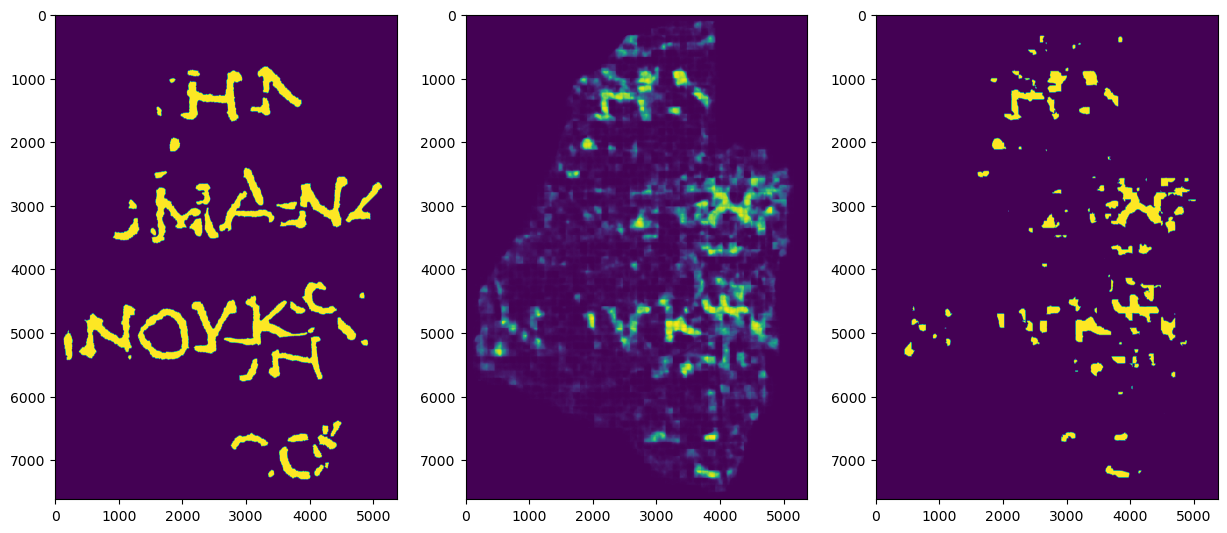

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([32080172.,  3076588.,  1242672.,   791047.,   581668.,   455482.,
          359464.,   301909.,   255409.,   224744.,   200301.,   178595.,
          163460.,   155673.,   165110.,   167447.,   172670.,   177031.,
          143873.,    50301.]),
 array([6.52659196e-07, 4.93901835e-02, 9.87797144e-02, 1.48169245e-01,
        1.97558776e-01, 2.46948307e-01, 2.96337838e-01, 3.45727369e-01,
        3.95116900e-01, 4.44506430e-01, 4.93895961e-01, 5.43285492e-01,
        5.92675023e-01, 6.42064554e-01, 6.91454085e-01, 7.40843616e-01,
        7.90233147e-01, 8.39622677e-01, 8.89012208e-01, 9.38401739e-01,
        9.87791270e-01]),
 <BarContainer object of 20 artists>)

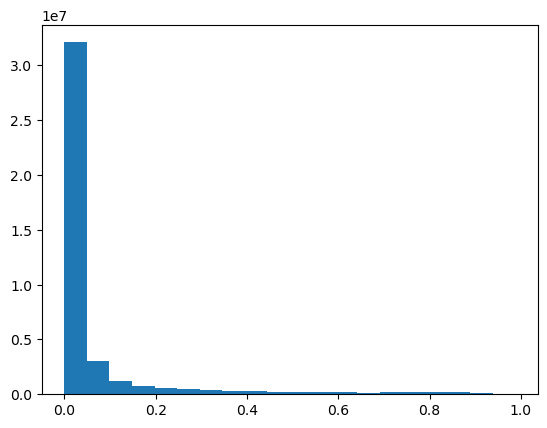

In [38]:
plt.hist(mask_pred.flatten(), bins=20)

In [39]:
# GPU VRAM 5.2GB/16.0GB A4000